In [1]:
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

In [2]:
def convert_file(shapefile, output_filename):
    valid = shapefile.geometry.apply(lambda x: True if x != None else False)
    shapefile = shapefile[valid]
    valid = shapefile['STE_NAME16'].apply(lambda x: True if x == 'Victoria' else False)
    shapefile = shapefile[valid]
    shapefile['LGA_NAME16'] = shapefile['LGA_NAME16'].apply(lambda x: x.split('(')[0].upper()
                                                           .replace('-', ' ')
                                                           .replace('SHIRE', '')
                                                           .replace('OF', '')
                                                           .replace('CITY', '')
                                                           .replace('RURAL', '')
                                                           .strip())
    shapefile.to_file(output_filename, driver = 'ESRI Shapefile')
    print("Saved file as", output_filename)

In [3]:
lgashp = gpd.read_file("./LGA_2016_AUST.shp")
convert_file(lgashp, "./out.shp")

Saved file as ./out.shp


In [4]:
lgashp = gpd.read_file('./out.shp')
lga1 = set(lgashp['LGA_NAME16'])
df = pd.read_csv('./lga-gambling-rate-clean.csv')
lga2 = set(df['LGA_NAME16'])

common = lga1.intersection(lga2)
lgashp = lgashp[lgashp['LGA_NAME16'].isin(common)]
lgashp.to_file('./out.shp', driver='ESRI Shapefile')
df = df[df['LGA_NAME16'].isin(common)]

D:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
D:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


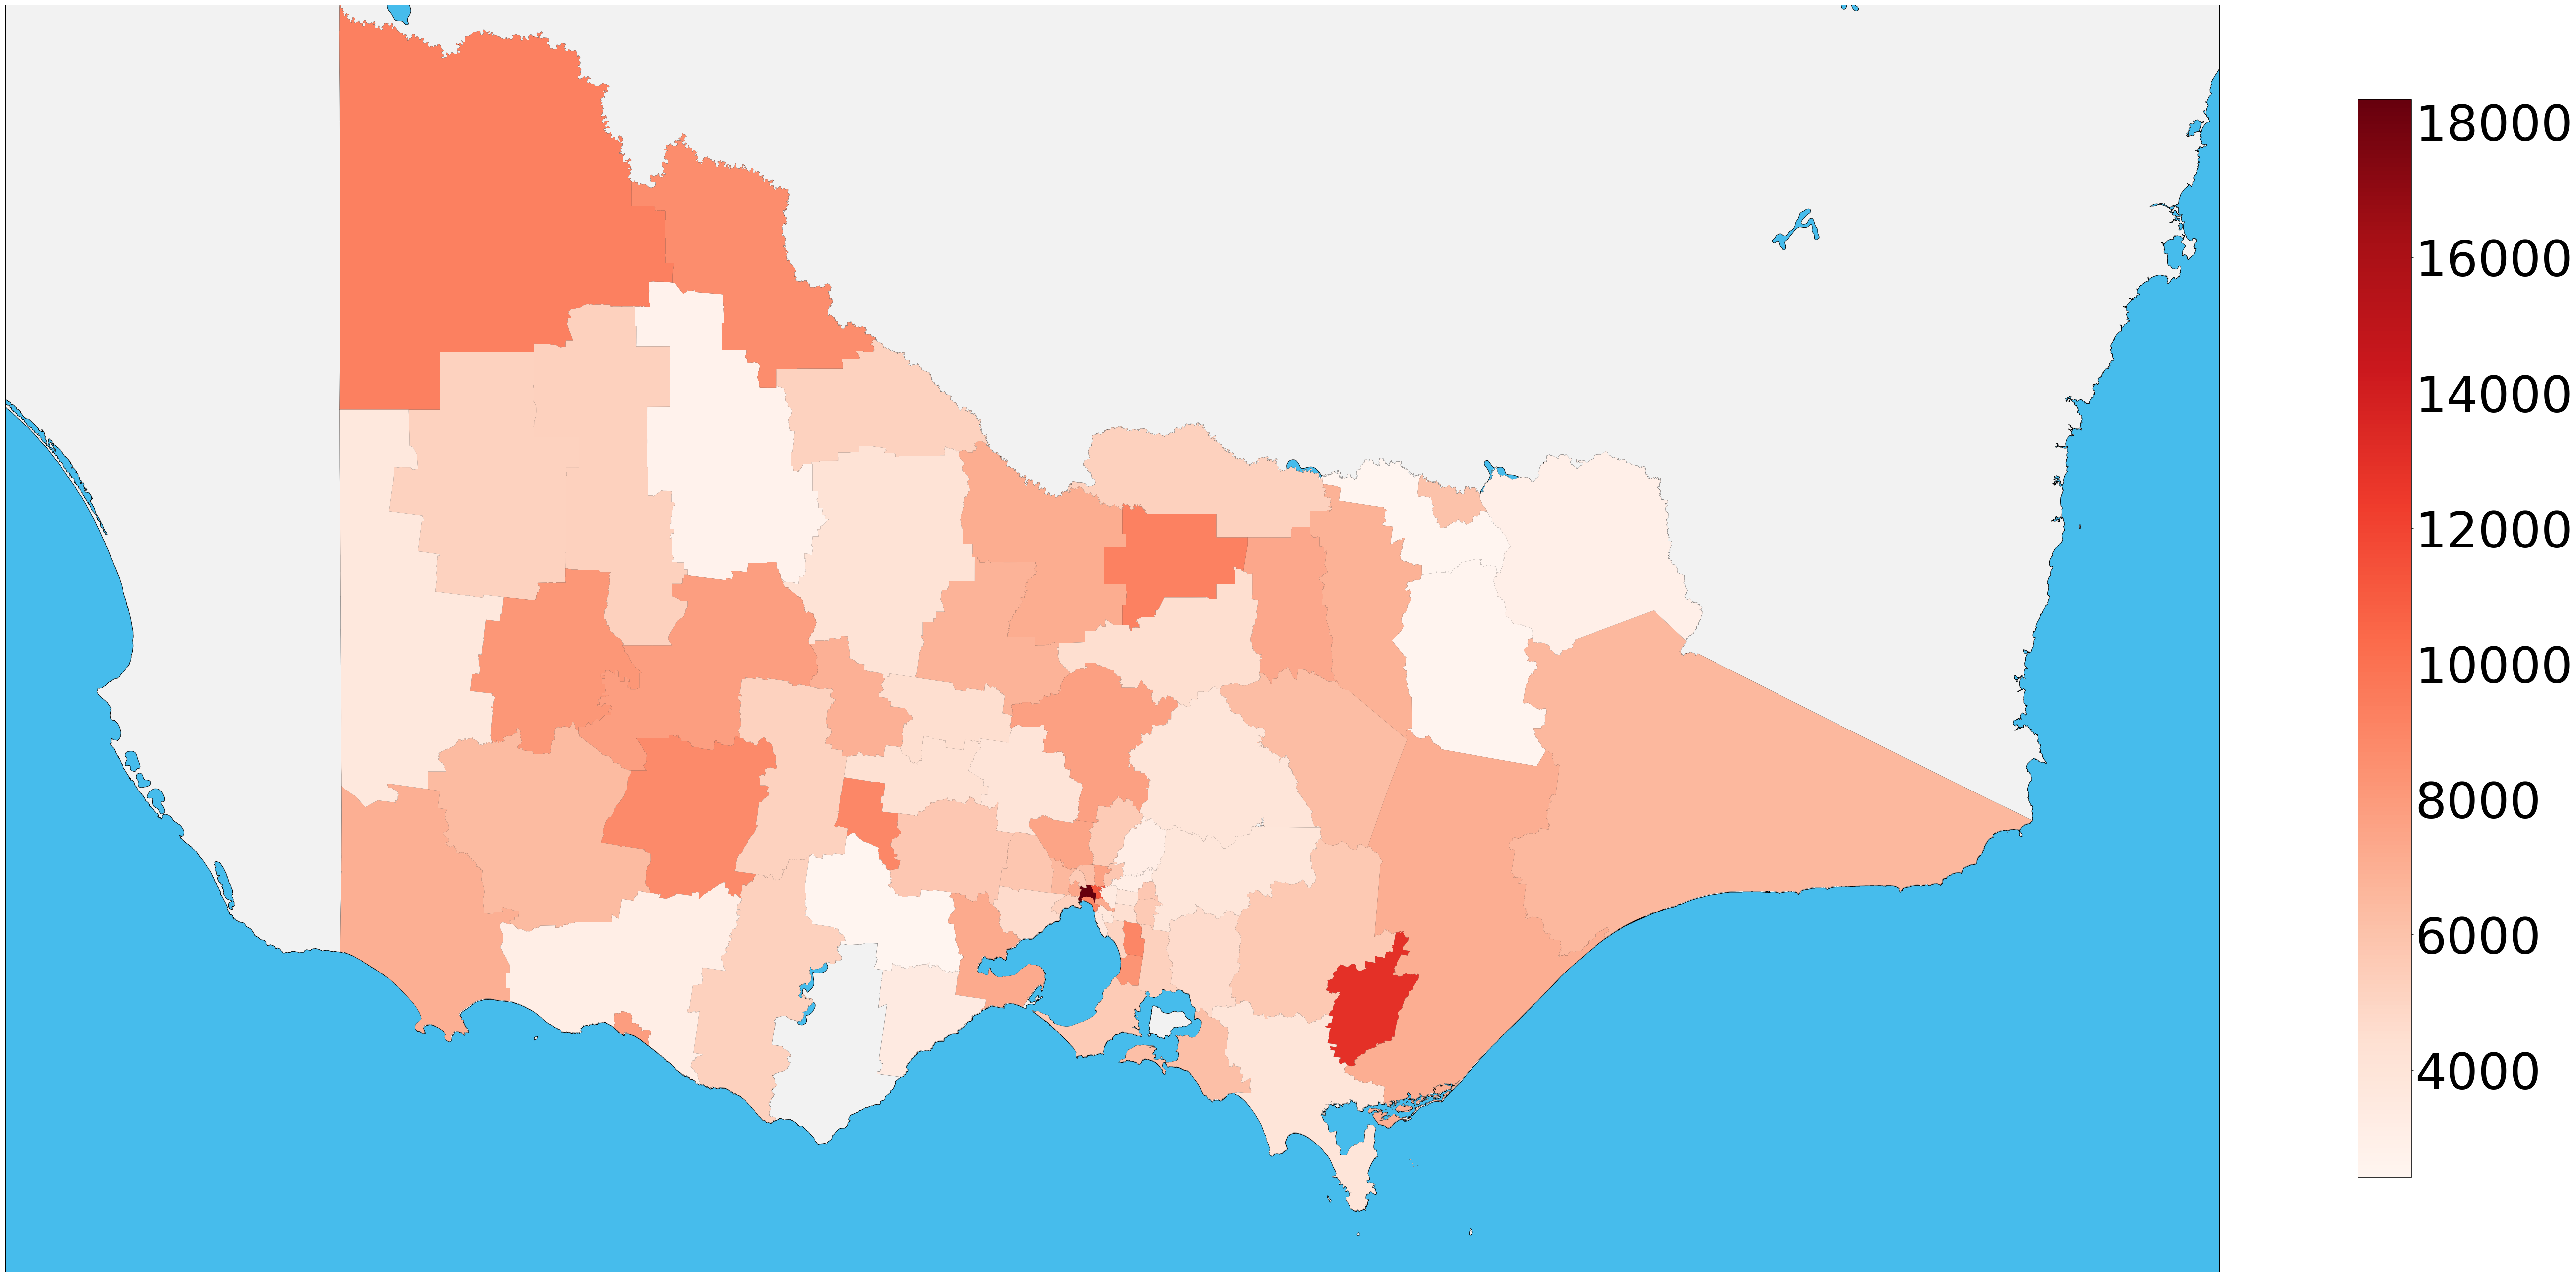

In [5]:
fig, ax = plt.subplots(figsize=(100, 100))
m = Basemap(projection='merc',llcrnrlat=-39.3866,urcrnrlat=-33.9813,
            llcrnrlon=139.1832,urcrnrlon=150.9715,resolution='f')
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('./out', 'area')
df_poly = pd.DataFrame({
    'shapes': [Polygon(np.array(shape), True) for shape in m.area],
    'LGA_NAME16': [area['LGA_NAME16'] for area in m.area_info]
})
df_poly = df_poly.merge(df, on='LGA_NAME16')
cmap = plt.get_cmap('Reds')
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
pc.set_facecolor(cmap(norm(df_poly['RATE'].values)))
ax.add_collection(pc)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(df_poly['RATE'])
cbar = plt.colorbar(mapper, shrink=0.4)
cbar.ax.tick_params(labelsize=100)
plt.savefig('choropleth.png', dpi=300)
plt.show()